In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

%cd "/content/gdrive/MyDrive/nlp/case_study/"

/content/gdrive/MyDrive/nlp/case_study


In [3]:
!python -m pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.tokenize import TweetTokenizer, RegexpTokenizer

In [5]:
df = pd.read_excel('Product_Review_Case_Study_Data_Excel.xlsx')

In [6]:
df['review'] =  df["review"].apply( lambda row: str(row).replace("[this review was collected as part of a promotion.]", "" ))

In [47]:
df['review']   = df["review"].apply( lambda row: str(row).replace("this review collected promotion", "" ))

In [48]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

In [49]:
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

In [50]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

In [51]:
df["review"]= df["review"].apply(expandContractions)

In [52]:
df["review"]= df["review"].apply(lambda x: x.replace("  "," "))

In [53]:
df["review"]=df["review"].apply(lambda x: x.lower())

In [54]:
df["review"] =df["review"].apply(lambda x: x.replace(".",""))

In [55]:
def remove_stop_words(text):
    words = [word for word in text.split() if word.lower() not in spacy_stop_words]
    new_text = " ".join(words)
    
    return new_text

In [56]:
import spacy
nlp = spacy.load('en_core_web_sm')
spacy_stop_words = nlp.Defaults.stop_words

In [57]:
df["review"] = df["review"].apply(remove_stop_words)

In [58]:
def lemma_text(text):
    doc = nlp(text)
    
    lemma_words = []
    for token in doc:
        lemma_words.append(token.lemma_)
        
    return lemma_words

In [59]:
import string
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans("", "", PUNCT_TO_REMOVE))

In [60]:
df["review"] = df["review"].apply(lambda text: remove_punctuation(text))

In [61]:
df["review"]

0                                                 cat died
1        cat picky enjoys fancy feast flavor he’s siame...
2        sub brand 3 segment food definitely received 4...
3        dog got sick hard find food loves food amazing...
4        recently adopted senior cat recently bad case ...
                               ...                        
12812    cat bad stomach issues plus allergic chicken c...
12813    dogs literally crazy brand 6 standard poodles ...
12814    dog thinks ok mean excited eat think good job ...
12815    brand 6 dental chews greatest find best way he...
12816    little dogs love treats shake wiggle package come
Name: review, Length: 12817, dtype: object

In [62]:
def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [63]:
df["review"] = df["review"].apply(lambda text: remove_emoji(str(text)))

In [64]:
df["review_lem"] = df["review"].apply(lemma_text)

In [65]:
from collections import Counter

In [66]:
# Get the top 20 most common words among all the articles
p_text = df['review_lem']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20


,word,frequency
0,dog,7652
1,love,7644
2,cat,6535
3,food,6228
4,treat,3676
5,brand,3352
6,like,3223
7,eat,3058
8,good,2108
9,great,2026


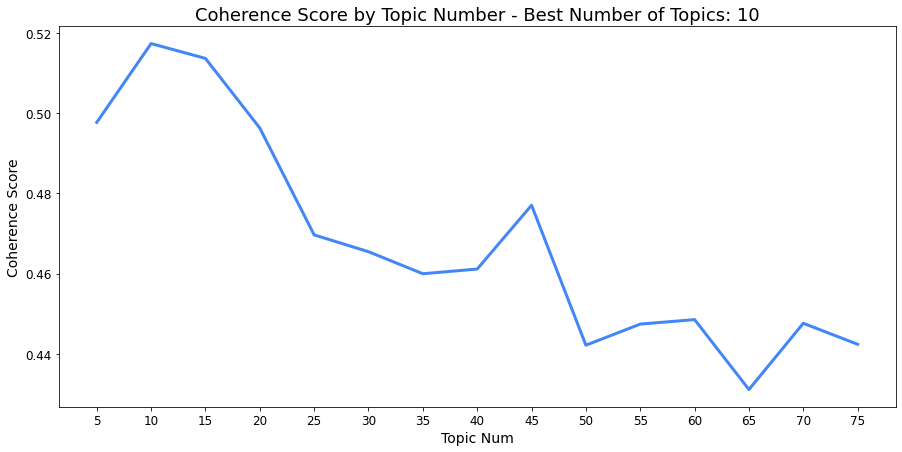

In [67]:

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['review_lem']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)



plt.show()

In [68]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['review_lem']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names_out()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [69]:
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


In [70]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

In [71]:
# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

In [72]:
def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


In [75]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 4

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list

topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

,0,1,2,3,topics
0,cat,cat love,love,treat,cat love treat
1,dog love,dog,love,love dog,dog love
2,food,eat,dog food,love food,food eat dog love
3,treat,breath,tooth,help,treat breath tooth help
4,not,do,do not,not like,not do like


In [76]:
topic_df.head(10)

,0,1,2,3,topics
0,cat,cat love,love,treat,cat love treat
1,dog love,dog,love,love dog,dog love
2,food,eat,dog food,love food,food eat dog love
3,treat,breath,tooth,help,treat breath tooth help
4,not,do,do not,not like,not do like
5,litter,box,cat,litter box,litter box cat
6,like,dog like,cat like,dog,like dog cat
7,cat,cat food,wet,food,cat food wet
8,great,product,price,great product,great product price
9,brand,love brand,flavor,17,brand love flavor 17


In [77]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,cat love treat
1,1,dog love
2,2,food eat dog love
3,3,treat breath tooth help
4,4,not do like
